In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from pandas_util import normalize_columns

plt.rcParams["figure.figsize"] = (20, 10)

In [14]:
mower_df = pd.read_csv("./datasets/dmba/RidingMowers.csv")
normalize_columns(mower_df)


def plot_decision_tree(df, *, max_depth=None):
    # use max_depth to control tree size (None = full tree)
    tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)

    X = df.drop(columns=["ownership"])
    y = df.ownership.astype("category")
    tree.fit(X, y)
    plot_tree(
        tree,
        feature_names=X.columns,
        class_names=y.cat.categories,
        filled=True,
        rounded=True,
    )

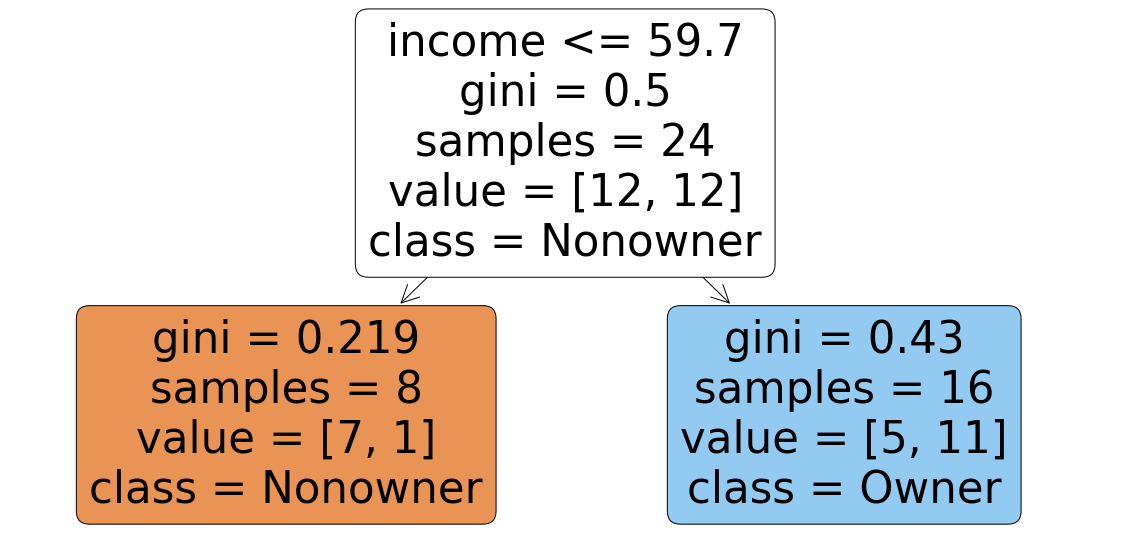

In [15]:
plot_decision_tree(mower_df, max_depth=1)

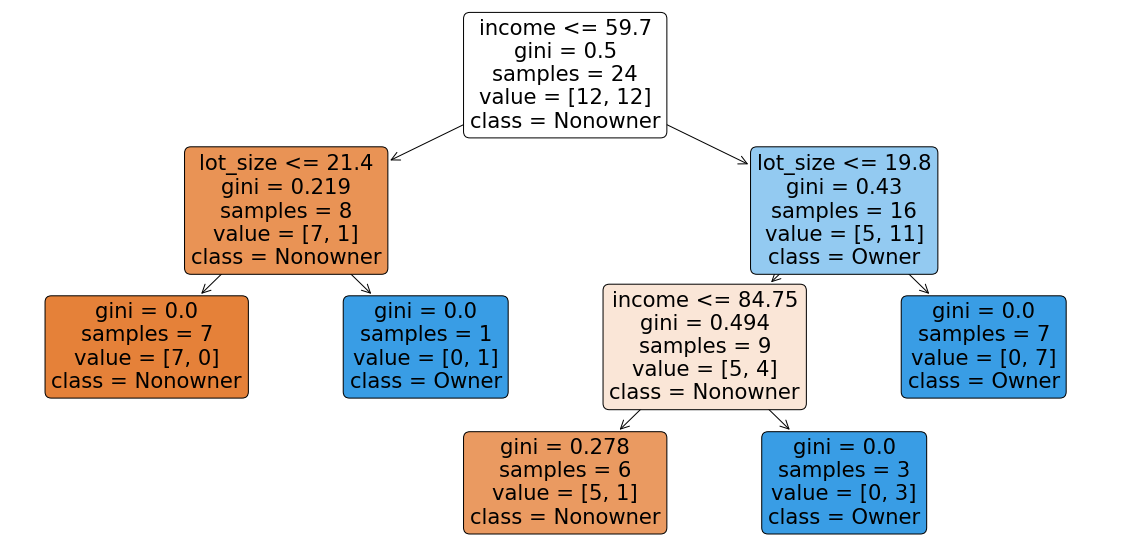

In [16]:
plot_decision_tree(mower_df, max_depth=3)

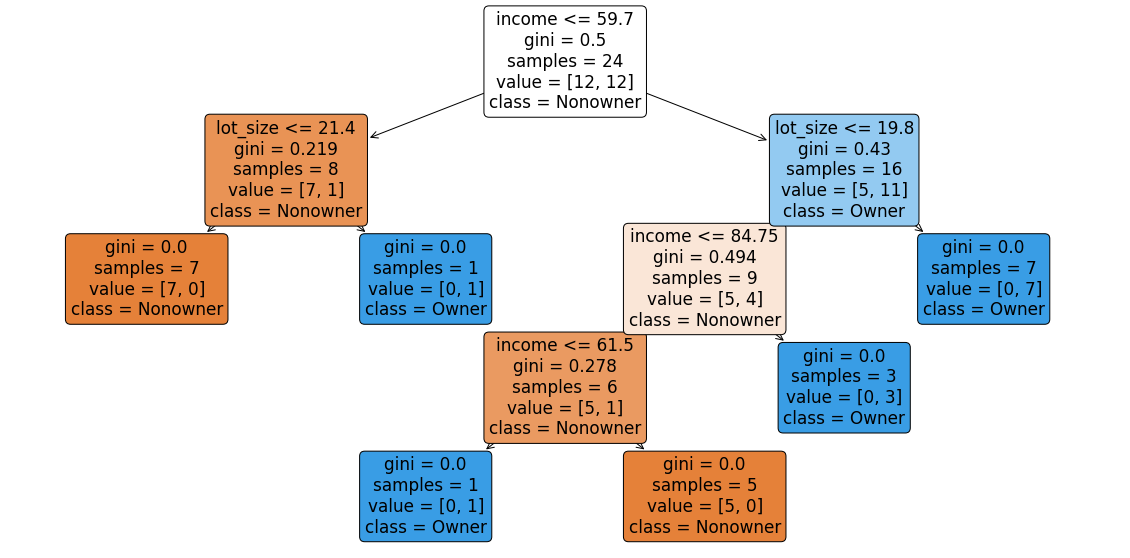

In [17]:
plot_decision_tree(mower_df, max_depth=None)

## Evaluating the performance of a classification tree

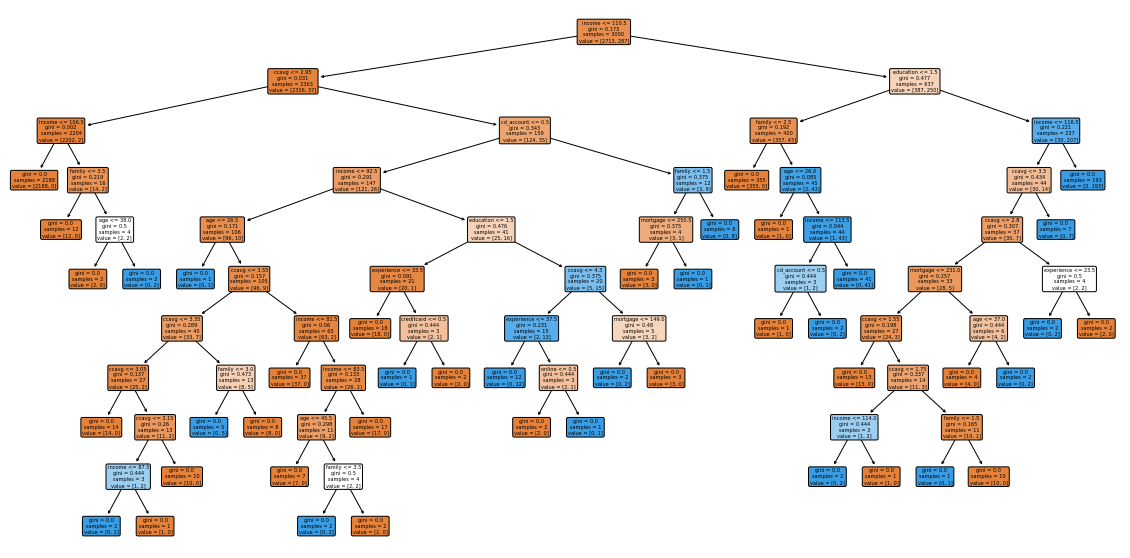

In [18]:
bank_df = pd.read_csv("./datasets/dmba/UniversalBank.csv")
normalize_columns(bank_df)
bank_df.drop(columns=["id", "zip_code"], inplace=True)

X = bank_df.drop(columns=["personal_loan"])
y = bank_df.personal_loan

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

tree = DecisionTreeClassifier(random_state=1)
tree.fit(train_X, train_y)
_ = plot_tree(tree, feature_names=train_X.columns, filled=True, rounded=True)

In [19]:
def classification_summary(*, y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()
    print("Classification report:")
    print(classification_report(y_true, y_pred))

In [20]:
classification_summary(y_true=train_y, y_pred=tree.predict(train_X))

Accuracy: 1.0

Confusion matrix:
[[2713    0]
 [   0  287]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2713
           1       1.00      1.00      1.00       287

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [21]:
classification_summary(y_true=test_y, y_pred=tree.predict(test_X))

Accuracy: 0.979

Confusion matrix:
[[1790   17]
 [  25  168]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1807
           1       0.91      0.87      0.89       193

    accuracy                           0.98      2000
   macro avg       0.95      0.93      0.94      2000
weighted avg       0.98      0.98      0.98      2000



## Accuracy of the default (full) classification tree using 5-fold cross-validation on the full tree.

<AxesSubplot:>

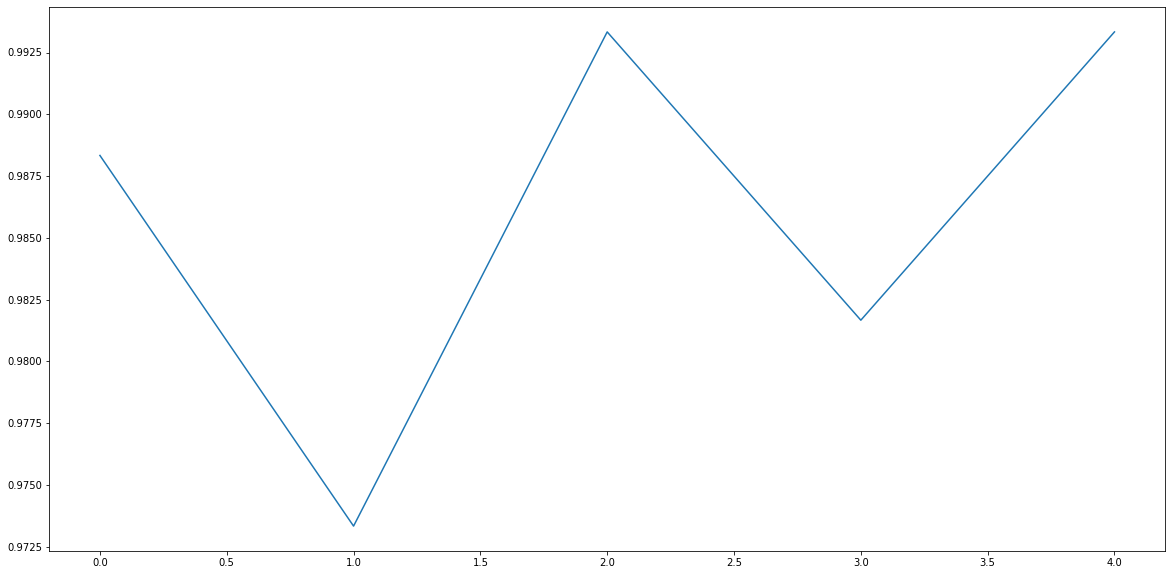

In [22]:
tree = DecisionTreeClassifier(random_state=1)
scores = cross_val_score(tree, train_X, train_y, cv=5)
pd.Series(scores).plot()

## Avoiding overfitting

In [26]:
small_tree = DecisionTreeClassifier(
    max_depth=30, min_samples_split=20, min_impurity_decrease=0.01, random_state=1
)
small_tree.fit(train_X, train_y)
classification_summary(y_true=train_y, y_pred=small_tree.predict(train_X))
classification_summary(y_true=test_y, y_pred=small_tree.predict(test_X))

Accuracy: 0.9823333333333333

Confusion matrix:
[[2711    2]
 [  51  236]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2713
           1       0.99      0.82      0.90       287

    accuracy                           0.98      3000
   macro avg       0.99      0.91      0.94      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.977

Confusion matrix:
[[1804    3]
 [  43  150]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1807
           1       0.98      0.78      0.87       193

    accuracy                           0.98      2000
   macro avg       0.98      0.89      0.93      2000
weighted avg       0.98      0.98      0.98      2000



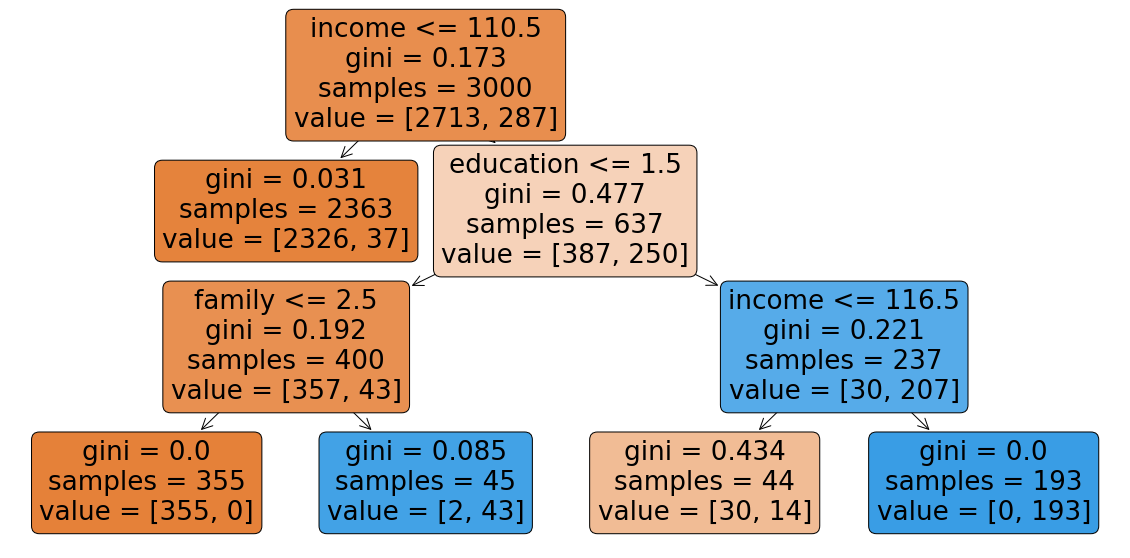

In [25]:
_ = plot_tree(
    small_tree,
    feature_names=test_X.columns,
    filled=True,
    rounded=True,
)

## Exhaustive grid search to fine tune method parameters

In [27]:
# Start with initial guess for parameters
param_grid = {
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [20, 40, 60, 80, 100],
    "min_impurity_decrease": [0, 0.0005, 0.001, 0.005, 0.01],
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1
)  # n_jobs=-1 will utilize all available CPU
grid_search.fit(train_X, train_y)
print("Initial score:", grid_search.best_score_)
print("Initial parameters:", grid_search.best_params_)

Initial score: 0.9876666666666667
Initial parameters: {'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 20}


In [28]:
# Adapt grid based on result from initial grid search.
param_grid = {
    "max_depth": list(range(2, 16)),
    "min_samples_split": list(range(10, 22)),
    "min_impurity_decrease": [0.0009, 0.001, 0.0011],
}
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1
)
grid_search.fit(train_X, train_y)
print("Improved score:", grid_search.best_score_)
print("Improved parameters:", grid_search.best_params_)

Improved score: 0.9873333333333333
Improved parameters: {'max_depth': 4, 'min_impurity_decrease': 0.0011, 'min_samples_split': 13}


In [29]:
best_class_tree = grid_search.best_estimator_

classification_summary(y_true=train_y, y_pred=best_class_tree.predict(train_X))
classification_summary(y_true=test_y, y_pred=best_class_tree.predict(test_X))

Accuracy: 0.9866666666666667

Confusion matrix:
[[2708    5]
 [  35  252]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2713
           1       0.98      0.88      0.93       287

    accuracy                           0.99      3000
   macro avg       0.98      0.94      0.96      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.9815

Confusion matrix:
[[1801    6]
 [  31  162]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1807
           1       0.96      0.84      0.90       193

    accuracy                           0.98      2000
   macro avg       0.97      0.92      0.94      2000
weighted avg       0.98      0.98      0.98      2000

